# Задание

1. [Датасет](https://archive.ics.uci.edu/dataset/856/higher+education+students+performance+evaluation) с данными про оценки студентов инженерного и педагогического факультетов (для данного датасета нужно ввести метрику: студент успешный/неуспешный на основании грейда)
2. Отобрать случайным образом sqrt(n) признаков
3. Реализовать без использования сторонних библиотек построение дерева решений (дерево не бинарное, numpy и pandas использовать можно, использовать список списков для реализации дерева - нельзя) для решения задачи бинарной классификации
4. Провести оценку реализованного алгоритма с использованием Accuracy, precision и recall
5. Построить кривые AUC-ROC и AUC-PR (в пунктах 4 и 5 использовать библиотеки нельзя)

# Решение

In [21]:
import pandas as pd
import numpy as np

In [22]:
file_path = './archive/data.csv'
data = pd.read_csv(file_path)

## Обработка данных
Отсутствующих данных в датасете нет, поэтому необходимости в их обработке нет.
Переименуем колонки для удобства работы с ними.

In [23]:
new_column_names = [
    "Student ID", "Student Age", "Sex", "Graduated high-school type", "Scholarship type", "Additional work", "Regular artistic or sports activity", "Do you have a partner", "Total salary if available", "Transportation to the university", "Accommodation type", "Mother's education", "Father's education", "Number of sisters/brothers", "Parental status", "Mother's occupation", "Father's occupation", "Weekly study hours", "Reading frequency (non-scientific books/journals)", "Reading frequency (scientific books/journals)", "Attendance to the seminars/conferences related to the department", "Impact of your projects/activities on your success", "Attendance to classes", "Preparation to midterm exams 1", "Preparation to midterm exams 2", "Taking notes in classes", "Listening in classes", "Discussion improves my interest and success in the course", "Flip-classroom", "Cumulative grade point average in the last semester", "Expected Cumulative grade point average in the graduation", "Course ID", "OUTPUT Grade"    
]

data.columns = new_column_names
data

,Student ID,Student Age,Sex,Graduated high-school type,Scholarship type,Additional work,Regular artistic or sports activity,Do you have a partner,Total salary if available,Transportation to the university,...,Preparation to midterm exams 1,Preparation to midterm exams 2,Taking notes in classes,Listening in classes,Discussion improves my interest and success in the course,Flip-classroom,Cumulative grade point average in the last semester,Expected Cumulative grade point average in the graduation,Course ID,OUTPUT Grade
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


## Определение бинарной метки успешности студента

Для задачи бинарной классификации необходимо преобразовать многоклассовую метку OUTPUT Grade в бинарную: успешный/неуспешный студент. Предположим, что студенты с оценкой OUTPUT Grade ≥ 4 считаются успешными, а остальные — неуспешными.

In [24]:
output_label, id_label = "OUTPUT Grade", "Student ID"
success_threshold = 1
success_label = "Success"

output_column = data[output_label]
success_column = output_column.apply(lambda x: 1 if x >= success_threshold else 0)
data[success_label] = success_column

output_classes = output_column.unique()
id_column = data[id_label]
data = data.drop(columns=[output_label, id_label, success_label])

Случайным образом отберем sqrt(n) признаков

In [25]:
sqrt_n = int(np.sqrt(len(data.columns)))

np.random.seed(2)
random_columns = np.random.choice(data.columns, sqrt_n, replace=False)
data = data[random_columns]
print(f"Selected columns: {sqrt_n} columns\n{random_columns}")
data

Selected columns: 5 columns
['Weekly study hours' 'Student Age'
 'Discussion improves my interest and success in the course'
 'Taking notes in classes' 'Number of sisters/brothers']


,Weekly study hours,Student Age,Discussion improves my interest and success in the course,Taking notes in classes,Number of sisters/brothers
0,3,2,1,3,3
1,2,2,3,3,2
2,2,2,1,2,2
3,3,1,2,3,5
4,2,2,2,2,2
...,...,...,...,...,...
140,3,2,2,2,2
141,3,1,2,3,5
142,2,1,2,3,4
143,2,2,2,2,1


## Дерево решений

Без использования сторонних библиотек построение дерева решений для решения задачи бинарной классификации.

Реализуем дерево решений по алгоритму C4.5, который использует отношение прироста информации (Information Gain Ratio) для выбора оптимальных признаков.

In [26]:
class DecisionTreeNode:
    def __init__(self, attribute=None, branches=None, is_leaf=False, prediction=None):
        self.attribute = attribute          # Атрибут для разбиения
        self.branches = branches or {}      # Дочерние узлы
        self.is_leaf = is_leaf              # Является ли узел листом
        self.prediction = prediction        # Предсказание класса (для листа)

    def predict_instance(self, instance):
        if self.is_leaf:
            return self.prediction
        attribute_value = instance.get(self.attribute)
        if attribute_value in self.branches:
            return self.branches[attribute_value].predict_instance(instance)
        else:
            # Если значение атрибута не встречалось при обучении, возвращаем наиболее частый класс
            return self.prediction


class DecisionTree:
    def __init__(self):
        self.root = None

    def entropy(self, y):
        class_counts = y.value_counts()
        probabilities = class_counts / len(y)
        return -sum(probabilities * np.log2(probabilities + 1e-9))  # Добавляем 1e-9 для избежания log(0)

    def information_gain_ratio(self, X, y, attribute):
        # Энтропия до разбиения
        entropy_before = self.entropy(y)

        # Группировка по значению атрибута
        values, counts = np.unique(X[attribute], return_counts=True)
        weighted_entropy = 0
        split_info = 0
        for v, count in zip(values, counts):
            subset_y = y[X[attribute] == v]
            subset_entropy = self.entropy(subset_y)
            weighted_entropy += (count / len(y)) * subset_entropy
            split_info -= (count / len(y)) * np.log2((count / len(y)) + 1e-9)

        info_gain = entropy_before - weighted_entropy
        gain_ratio = info_gain / (split_info + 1e-9)  # Добавляем 1e-9 для избежания деления на ноль
        return gain_ratio

    def build_tree_recursive(self, X, y, attributes, default_class=None):
        if len(y) == 0:
            return DecisionTreeNode(is_leaf=True, prediction=default_class)
        elif len(y.unique()) == 1:
            return DecisionTreeNode(is_leaf=True, prediction=y.iloc[0])
        elif len(attributes) == 0:
            majority_class = y.mode()[0]
            return DecisionTreeNode(is_leaf=True, prediction=majority_class)
        else:
            default_class = y.mode()[0]
            # Выбор атрибута с максимальным Gain Ratio
            gain_ratios = {attr: self.information_gain_ratio(X, y, attr) for attr in attributes}
            best_attr = max(gain_ratios, key=gain_ratios.get)

            tree = DecisionTreeNode(attribute=best_attr, prediction=default_class)
            # Разбиение по значениям лучшего атрибута
            for attr_val in np.unique(X[best_attr]):
                subset_X = X[X[best_attr] == attr_val].drop(columns=[best_attr])
                subset_y = y[X[best_attr] == attr_val]
                subtree = self.build_tree_recursive(
                    subset_X,
                    subset_y,
                    [attr for attr in attributes if attr != best_attr],
                    default_class=default_class
                )
                tree.branches[attr_val] = subtree
            return tree

    def build_tree(self, X, y):
        attributes = list(X.columns)
        self.root = self.build_tree_recursive(X, y, attributes)
        print("Дерево решений построено.")

    def predict_instance(self, instance):
        return self.root.predict_instance(instance)

    def predict(self, X):
        return X.apply(self.predict_instance, axis=1).values

    def __str__(self):
        lines = []
        self._str_recursive(self.root, lines, "")
        return "\n".join(lines)

    def _str_recursive(self, node, lines, prefix):
        if node.is_leaf:
            lines.append(f"{prefix}Leaf: {node.prediction}")
        else:
            lines.append(f"{prefix}Attribute: {node.attribute}")
            for value, subtree in node.branches.items():
                lines.append(f"{prefix} ├─ {value} -> ")
                self._str_recursive(subtree, lines, prefix + " │  ")


def calculate_auc(y_true, y_scores, curve_type='ROC'):
    # Сортируем по убыванию вероятностей
    desc_score_indices = np.argsort(-y_scores)
    y_true = y_true[desc_score_indices]
    y_scores = y_scores[desc_score_indices]

    # Уникальные значения
    distinct_value_indices = np.where(np.diff(y_scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps

    tps = np.r_[0, tps]
    fps = np.r_[0, fps]

    if curve_type == 'ROC':
        fpr = fps / fps[-1]
        tpr = tps / tps[-1]
        auc = np.trapezoid(tpr, fpr)
        return fpr, tpr, auc
    elif curve_type == 'PR':
        precision = tps / (tps + fps + 1e-9)
        recall = tps / tps[-1]
        auc = np.trapezoid(precision, recall)
        return recall, precision, auc
    else:
        raise ValueError("curve_type должен быть 'ROC' или 'PR'")


def calculate_auc_metrics(y_true, y_pred):
    # Используем y_pred как бинарные вероятности
    y_scores = y_pred
    # Расчет AUC-ROC
    fpr, tpr, auc_roc = calculate_auc(y_true, y_scores, curve_type='ROC')
    # Расчет AUC-PR
    recall, precision, auc_pr = calculate_auc(y_true, y_scores, curve_type='PR')
    return (fpr, tpr, auc_roc), (recall, precision, auc_pr)



## Разделение данных на обучающую и тестовую выборки

In [27]:
def train_test_split(X, y, test_size=0.2, random_state=1):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

X_train, X_test, y_train, y_test = train_test_split(data, success_column, test_size=0.2, random_state=1)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 116
Размер тестовой выборки: 29


## Обучение дерева решений

In [28]:
# Получение списка признаков
attributes = list(X_train.columns)

# Построение дерева
tree = DecisionTree()
tree.build_tree(X_train, y_train)
print(tree)

Дерево решений построено.
Attribute: Discussion improves my interest and success in the course
 ├─ 1 -> 
 │  Attribute: Taking notes in classes
 │   ├─ 1 -> 
 │   │  Leaf: 0
 │   ├─ 2 -> 
 │   │  Leaf: 1
 │   ├─ 3 -> 
 │   │  Leaf: 1
 ├─ 2 -> 
 │  Attribute: Student Age
 │   ├─ 1 -> 
 │   │  Attribute: Number of sisters/brothers
 │   │   ├─ 1 -> 
 │   │   │  Attribute: Weekly study hours
 │   │   │   ├─ 1 -> 
 │   │   │   │  Attribute: Taking notes in classes
 │   │   │   │   ├─ 2 -> 
 │   │   │   │   │  Leaf: 0
 │   │   │   │   ├─ 3 -> 
 │   │   │   │   │  Leaf: 1
 │   │   │   ├─ 2 -> 
 │   │   │   │  Leaf: 1
 │   │   │   ├─ 3 -> 
 │   │   │   │  Leaf: 1
 │   │   ├─ 2 -> 
 │   │   │  Attribute: Taking notes in classes
 │   │   │   ├─ 2 -> 
 │   │   │   │  Leaf: 1
 │   │   │   ├─ 3 -> 
 │   │   │   │  Attribute: Weekly study hours
 │   │   │   │   ├─ 2 -> 
 │   │   │   │   │  Leaf: 0
 │   │   │   │   ├─ 4 -> 
 │   │   │   │   │  Leaf: 1
 │   │   ├─ 3 -> 
 │   │   │  Attribute: Weekly s

## Оценка качества модели

In [29]:
def compute_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    confusion_matrix = np.array([[TN, FP], [FN, TP]])
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-9)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    
    return confusion_matrix, accuracy, precision, recall

def predict(tree, X):
    predictions = []
    for _, instance in X.iterrows():
        instance_dict = instance.to_dict()
        prediction = tree.predict_instance(instance_dict)
        predictions.append(prediction)
    return np.array(predictions)


y_pred = tree.predict(X_test)
confusion_matrix, accuracy, precision, recall = compute_metrics(y_test.values, y_pred)
print(f"Confusion matrix:\n{confusion_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Confusion matrix:
[[ 0  1]
 [ 3 25]]
Accuracy: 0.8621
Precision: 0.9615
Recall: 0.8929


## Построение кривых AUC-ROC и AUC-PR

Для построения кривых AUC-ROC и AUC-PR необходимо получить вероятности принадлежности к классу 1 для каждого объекта тестовой выборки. Для этого воспользуемся функцией predict_proba, которая возвращает вероятности принадлежности к классам 0 и 1.

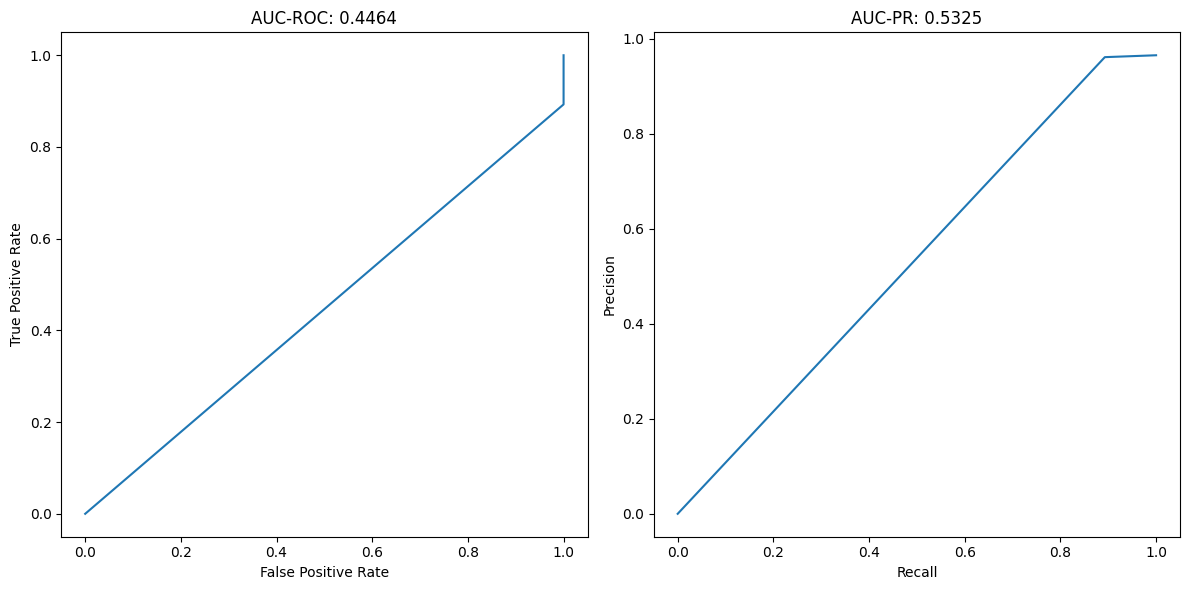

In [30]:
def predict_proba(tree, X):
    predictions = []
    for _, instance in X.iterrows():
        instance_dict = instance.to_dict()
        prediction = tree.predict_instance(instance_dict)
        # Вероятность принадлежности к классу 1
        proba = 1 if prediction == 1 else 0
        predictions.append(proba)
    return np.array(predictions)

y_scores = predict_proba(tree, X_test)
auc_roc, auc_pr = calculate_auc_metrics(y_test.values, y_scores)
# Построим кривые
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(auc_roc[0], auc_roc[1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"AUC-ROC: {auc_roc[2]:.4f}")

plt.subplot(1, 2, 2)
plt.plot(auc_pr[0], auc_pr[1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"AUC-PR: {auc_pr[2]:.4f}")

plt.tight_layout()
plt.show()